In [2]:
library(edgeR)
library(magrittr)
library(ggplot2)
#library(DESeq2)
library(MAST)
library(tidyr)
library(dplyr)
library(reshape)
library(Seurat)
#library(SeuratDisk)
require(scales)
library(gplots)
library(reshape2)
library(anndata)
library(reticulate)

In [3]:
h5ad_file <- "./CTCL/object_revision/skin_atlas_ctcl_TNK_20240707.h5ad"
sdata <- read_h5ad(h5ad_file)
sdata <- CreateSeuratObject(counts = t(as.matrix(sdata$X)), meta.data = sdata$obs)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 42.4 GiB”


In [3]:
pseudobulk <- function(seurat_object, column, label){
    seurat_object@meta.data[,column] <- as.character(seurat_object@meta.data[,column])
    tmp <- seurat_object[,seurat_object@meta.data[,column]==label]
    tmp2 <- Matrix::rowSums(tmp@assays$RNA@counts)
    return(tmp2)
}

### column -- donor_id
### label -- each donor
### raw counts

In [5]:
saveRDS(sdata, file = "./CTCL/object_revision/skin_atlas_ctcl_TNK_20240707.rds")

In [4]:
sdata <- readRDS("./CTCL/object_revision/skin_atlas_ctcl_TNK_20240707.rds")

In [5]:
sdata$type %>% table

.
tumor_cell 
    132195 

In [6]:
sdata$sample_type %>% table

.
          AD         CTCL healthy_skin    psoriasis 
       30821       263987        45046        24186 

In [7]:
sdata$Site_condition <- paste(sdata$sample_type, sdata$site, sep='_')
sdata$Site_condition %>% table

.
              AD_lesion           AD_non_lesion             CTCL_lesion 
                  19439                   11382                  263987 
healthy_skin_non_lesion        psoriasis_lesion    psoriasis_non_lesion 
                  45046                   18935                    5251 

In [8]:
Target_subset <- subset(sdata, cells = 
               rownames(sdata@meta.data)[which(sdata$Site_condition == 'healthy_skin_non_lesion' |
                                               sdata$Site_condition == 'CTCL_lesion' |
                                               sdata$Site_condition == 'AD_lesion' |
                                               sdata$Site_condition == 'psoriasis_lesion')]) ### lesional only

In [13]:
Target_subset$cell_type[is.na(Target_subset$cell_type)] <- 'tumor_cell'

In [14]:
Target_subset$cell_type %>% table

.
      ILC1_3      ILC1_NK         ILC2           NK           Tc    Tc17_Th17 
        5952         3618          759         4117        58143         7841 
Tc_IL13_IL22           Th         Treg   tumor_cell 
        9211        85136        40435       132195 

In [15]:
Target_subset <- subset(Target_subset, cells = 
                        rownames(Target_subset@meta.data)[which(Target_subset$cell_type != 'NK' &
                                                                Target_subset$cell_type != 'ILC1_3' &
                                                                Target_subset$cell_type != 'ILC1_NK' &
                                                                Target_subset$cell_type != 'ILC2')])
Target_subset

An object of class Seurat 
15636 features across 332961 samples within 1 assay 
Active assay: RNA (15636 features, 0 variable features)

In [16]:
Target_subset$Type <- rep('others', nrow(Target_subset@meta.data))
Target_subset$Type[which(Target_subset$type == 'tumor_cell')] <- 'tumour'

In [17]:
Target_subset$Type %>% table

.
others tumour 
200766 132195 

In [19]:
table(Target_subset$donor)


          CTCL1           CTCL2           CTCL3           CTCL4           CTCL5 
           9254            5270           13210           12427           14919 
          CTCL6           CTCL7           CTCL8              E1              E2 
          17494           55751           11953             500            2149 
             E3              E4            MF14            MF15            MF17 
           6915            9242            4364            1291            4861 
           MF18            MF21            MF22            MF26            MF27 
            714            2803            1088            1757            1652 
           MF28            MF30           MF309           MF311           MF312 
          14342            5022           10161           14487             306 
             P1              P2              P3             P65             P73 
           4321            8366            4965             814             331 
            P84            

In [20]:
Target_subset$donor <- as.character(Target_subset$donor)

Target_subset$donor[which(Target_subset$Type == "others" &
                             Target_subset$Site_condition == "CTCL_lesion")] <- paste0(Target_subset$donor[which(Target_subset$Type == "others" &
                             Target_subset$Site_condition == "CTCL_lesion")], '_N')

In [21]:
table(Target_subset$donor)


            CTCL1           CTCL1_N             CTCL2           CTCL2_N 
             8069              1185              1907              3363 
            CTCL3           CTCL3_N             CTCL4           CTCL4_N 
             9524              3686              1073             11354 
            CTCL5           CTCL5_N             CTCL6           CTCL6_N 
             7724              7195              3773             13721 
            CTCL7           CTCL7_N             CTCL8           CTCL8_N 
             3673             52078              7139              4814 
               E1                E2                E3                E4 
              500              2149              6915              9242 
             MF14            MF14_N              MF15            MF15_N 
             4183               181              1146               145 
             MF17            MF17_N            MF18_N              MF21 
             3769              1092               

In [22]:
mat <- c()
coln <- c()
for (name in as.vector(sort(unique(Target_subset$donor)))) {
     pp <- pseudobulk(Target_subset, 'donor', name)
     mat <- cbind(mat, pp)
     coln <- c(coln, name)
} 
colnames(mat) <- coln
rownames(mat) <- rownames(Target_subset@assays$RNA@counts)
#mat <- mat[VariableFeatures(object = Target_subset), ]
dim(mat)

[1] 15636    88

In [23]:
mat[1:5,]

,CTCL1,CTCL1_N,CTCL2,CTCL2_N,CTCL3,CTCL3_N,CTCL4,CTCL4_N,CTCL5,CTCL5_N,⋯,PT53_N,PT55,PT55_N,PT56,PT56_N,S1,S2,S3,S4,S5
SAMD11,8,1,0,0,8,0,1,0,13,1,⋯,0,0,0,0,0,2,3,1,1,0
NOC2L,2475,236,708,376,6214,541,223,974,2259,905,⋯,166,627,33,169,486,667,677,408,1386,1674
KLHL17,63,20,27,15,144,34,17,58,151,38,⋯,9,89,1,5,31,70,47,21,128,158
PLEKHN1,0,11,25,14,63,7,26,43,206,56,⋯,14,140,5,20,42,94,42,26,88,212
HES4,84,9,70,3,41,18,1,8,253,37,⋯,25,61,0,2,24,143,4,0,11,46


In [24]:
Condition <- "tumour" #### Physiological conditions

control <- as.vector(unique(Target_subset$donor
                            [which(Target_subset$Type != Condition)]))
mut <- as.vector(unique(Target_subset$donor
                        [which(Target_subset$Type == Condition)]))
sub <- c(control, mut)
mat_sub <- mat[, sub]
groups <- factor(c(rep(1, length(control)), rep(2, length(mut))))

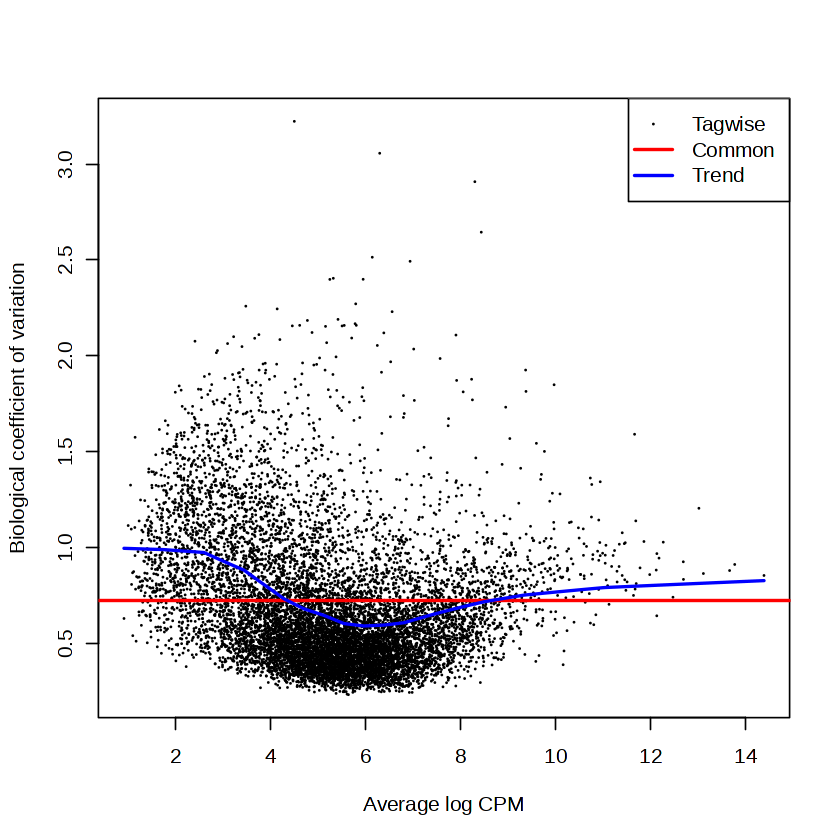

In [31]:
#########edgeR#########
DEGs <- DGEList(counts=mat_sub, group=groups)

#keep <- filterByExpr(DEGs, min.count=50, min.total.count=100)
keep <- filterByExpr(DEGs)
DEGs <- DEGs[keep, , keep.lib.sizes=FALSE]

DEGs <- calcNormFactors(DEGs)

#cdr <- scale(colMeans(mat_sub > 0))
#design <- model.matrix(~cdr+groups)
design <- model.matrix(~groups)

DEGs <- estimateDisp(DEGs, design = design)
fit <- glmQLFit(DEGs, design = design)
qlf <- glmQLFTest(fit,coef=2)
tt <- topTags(qlf, n = Inf)
plotBCV(DEGs)

et <- exactTest(DEGs)
et_FDR <- topTags(et, n = nrow(et$table), adjust.method = "BH", sort.by = "PValue", p.value = 1)

out_temp <- et_FDR$table

In [32]:
#out_temp
edge_mut_up <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC>0), ]
edge_mut_down <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC<0), ]

In [33]:
edge_mut_down %>% head

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
KLRG1,-2.749797,5.042310,8.204122e-24,8.697190e-20
CD8A,-4.269271,8.109208,2.466715e-22,9.619647e-19
RASA3,-2.319269,5.697017,1.671820e-21,3.544593e-18
KLRD1,-3.633756,4.927243,2.415561e-21,4.267894e-18
KLRC4,-4.229804,5.204796,3.121348e-21,4.727059e-18
FOXP3,-4.014631,6.833684,3.379057e-20,4.477673e-17


In [34]:
write.table(out_temp, file='./Pseudobulk_DEG_all_filterByDefault.xls',quote=F,sep="\t")